# Data Visualisation
## 1. Data production park the Netherlands

Getting the data from multiple production parks in the Netherlands and cleaning this up and visualizing trends

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as d
import numpy as np
import statsmodels.api as sm
import pylab as py
from scipy import stats

In [3]:
!pip install pandas
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: C:\Users\Robbe\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: C:\Users\Robbe\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: C:\Users\Robbe\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [4]:
prodNL = pd.read_parquet('production.parquet', engine='pyarrow')
metadata = pd.read_csv("installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata.head(10)

,Watt Peak,Azimuth,Orientation,Tilt,ZIP_NL,Plaats,Latitude,Longitude
id,,,,,,,,
1183SB10,2480,113,-67,35,1183,Amstelveen,52.30864,4.88959
1183RW15,2480,202,22,35,1183,Amstelveen,52.30864,4.88959
1185PS233,1240,180,0,13,1185,Amstelveen,52.29065,4.85156
1791AW12,1240,90,-90,10,1791,Den Burg,53.05392,4.79605
1791AW12B,1240,90,-90,10,1791,Den Burg,53.05392,4.79605
2645JE56,2170,160,-20,25,2645,Delfgauw,52.00861,4.39657
2678WH10,2440,248,68,45,2678,De Lier,51.97790,4.25496
2678WG17,2440,115,-65,45,2678,De Lier,51.97790,4.25496
2678WH4,2440,248,68,45,2678,De Lier,51.97790,4.25496


In [5]:
prodNL.tail(10)

watt
id       timestamp                
9851BB13 2021-08-09 18:15:00  40.0
         2021-08-09 18:30:00   0.0
         2021-08-09 18:45:00  40.0
         2021-08-09 19:00:00   0.0
         2021-08-09 19:15:00   0.0
         2021-08-09 19:30:00   0.0
         2021-08-09 19:45:00   0.0
         2021-08-09 20:00:00   0.0
         2021-08-09 20:15:00   0.0
         2021-08-09 20:30:00   0.0

In [4]:
#Check if there are NaN values or missing datetimes
print(prodNL.isnull().values.any())
for unique_id, installation_prod in prodNL.groupby(level=0):
    installation_prod.index = installation_prod.index.droplevel(0)
    start = installation_prod.index.min()
    end = installation_prod.index.max()
    metadata.loc[unique_id, "start"] = start
    metadata.loc[unique_id, "end"] = end
    expected_timestamps = pd.date_range(start=start, end=end, freq='15T')  # Assuming data is recorded every 15 minutes
    
    missing_timestamps = expected_timestamps[~expected_timestamps.isin(installation_prod.index)]
    
    if not missing_timestamps.empty:
        print(f"ID: {unique_id}, Missing Timestamps: {missing_timestamps}")
    else:
        print(f"ID: {unique_id}, No missing chronological data.")


    #Check if there are values above peak power
    peak_power = metadata.at[unique_id, 'Watt Peak']
    print(installation_prod[['watt']].gt(peak_power).any(axis=1).sum())

#Check if there are values smaller than 0
prodNL[["watt"]].lt(0).any(axis=1).sum()

False
ID: 1183RW15, No missing chronological data.
0
ID: 1183SB10, No missing chronological data.
0
ID: 1185PS233, No missing chronological data.
0
ID: 1791AW12, No missing chronological data.
0
ID: 1791AW12B, No missing chronological data.
0
ID: 2645JE56, No missing chronological data.
0
ID: 2678WG17, No missing chronological data.
0
ID: 2678WH10, No missing chronological data.
0
ID: 2678WH4, No missing chronological data.
0
ID: 2993AM21, No missing chronological data.
0
ID: 2993AP7, No missing chronological data.
0
ID: 3343EH47, No missing chronological data.
0
ID: 3343EH67, No missing chronological data.
0
ID: 3437BD60, No missing chronological data.
0
ID: 3551XT40, No missing chronological data.
0
ID: 3705PN116, No missing chronological data.
0
ID: 3994TC15, No missing chronological data.
0
ID: 4131AE11, No missing chronological data.
0
ID: 4131CC21, No missing chronological data.
0
ID: 4251BW7, No missing chronological data.
0
ID: 4891XX2, No missing chronological data.
0
ID: 4901

0

### Plotting

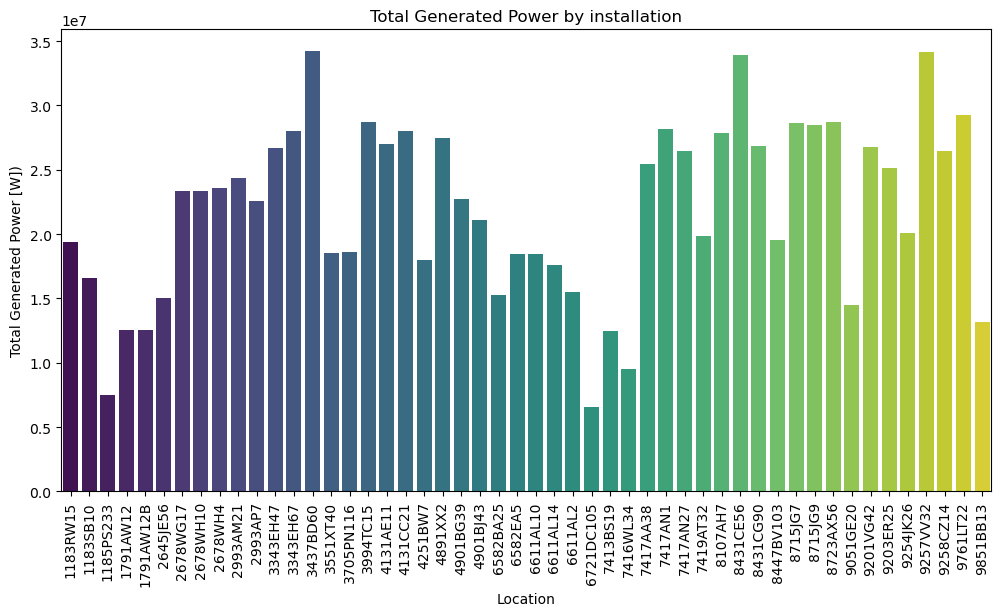

In [128]:
installation_power = prodNL.groupby('id')['watt'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='id', y='watt', data=installation_power, palette='viridis')
plt.title('Total Generated Power by installation')
plt.xlabel('Location')
plt.ylabel('Total Generated Power [W])')
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.show()

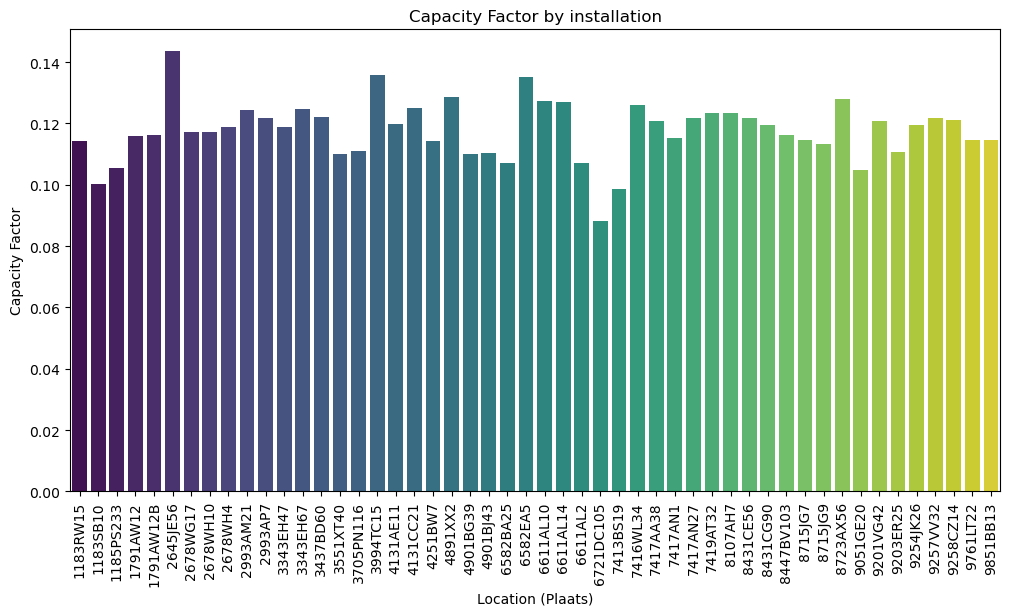

In [129]:

#
nb_of_days = (metadata.end-metadata.start).dt.days
nb_of_days.head()
installation_power.set_index('id', inplace= True, drop = True)
installation_power["nb_days"] = nb_of_days
installation_power["Watt Peak"] = metadata['Watt Peak']
installation_power["cf"] = installation_power['watt']/(24*4*installation_power["nb_days"]*installation_power['Watt Peak'])

# Create a bar graph for capacity factor using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=installation_power.index, y='cf', data=installation_power, palette='viridis')
plt.title('Capacity Factor by installation')
plt.xlabel('Location (Plaats)')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


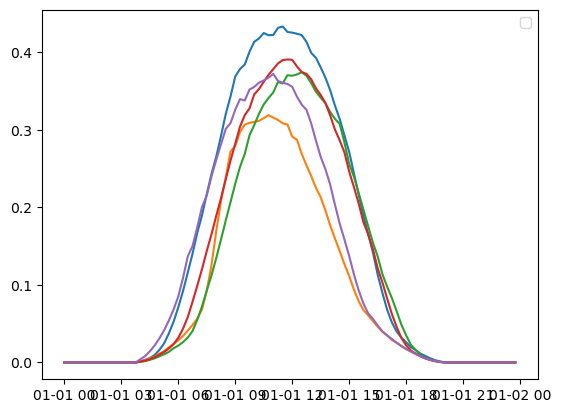

In [151]:
#Select some ID's of diverse locations in terms of total generated power and CF
ID_selection = ('2645JE56', '6721DC105', '1183RW15', '3437BD60', '9851BB13')

#Plot average daily generation profile for each location
for unique_id in ID_selection:
    installation_prod = prodNL.loc[(unique_id,)]
    peak_power = metadata.at[unique_id, 'Watt Peak']
    installation_prod['hour'] = installation_prod.index.hour
    installation_prod['minute'] = installation_prod.index.minute
    daily_profile = installation_prod.groupby(['hour', 'minute']).mean()/peak_power
    # Create a bar graph for capacity factor using seaborn
    daily_profile.index = pd.to_datetime(daily_profile.index.map(lambda x: f'{x[0]:02d}:{x[1]:02d}'), format='%H:%M')
    # Setting 'Time' as the DateTime index
    plt.plot(daily_profile)
    plt.legend()

C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(installation_prod['watt'], hist = False, kde = True,
c:\Users\Robbe\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

Lambda value used for Transformation: 0.2600099542371092


C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(installation_prod['watt'], hist = False, kde = True,
c:\Users\Robbe\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

Lambda value used for Transformation: -0.024520034273852756


C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(installation_prod['watt'], hist = False, kde = True,
c:\Users\Robbe\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

Lambda value used for Transformation: 0.16158972511971337


C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(installation_prod['watt'], hist = False, kde = True,
c:\Users\Robbe\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

Lambda value used for Transformation: 0.2625919574862431


C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(installation_prod['watt'], hist = False, kde = True,
c:\Users\Robbe\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\Robbe\AppData\Local\Temp\ipykernel_23340\458033220.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

Lambda value used for Transformation: 0.12113988088352047


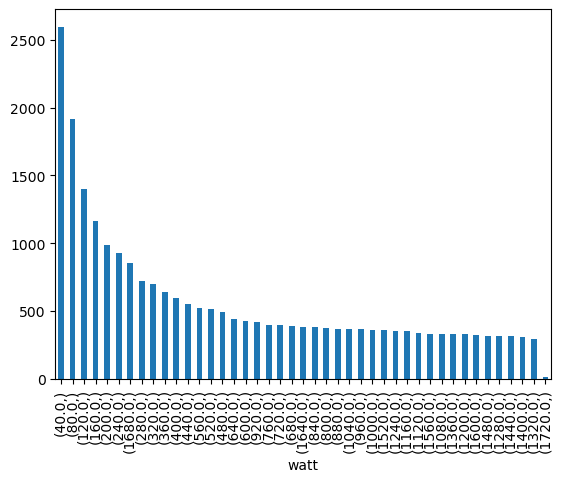

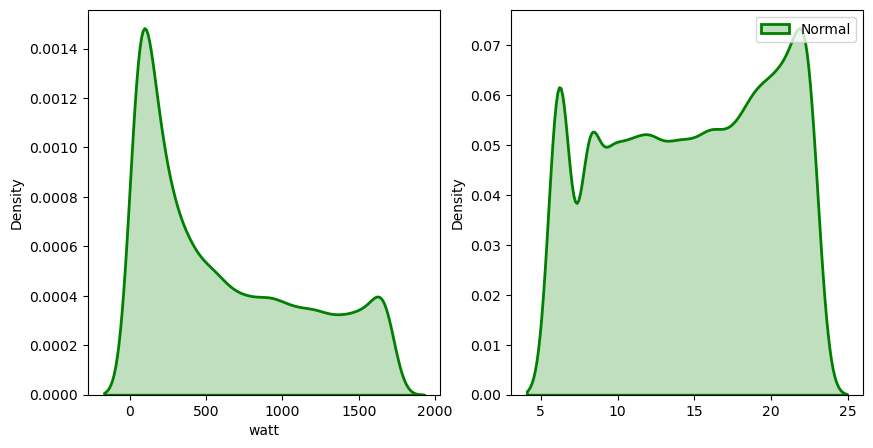

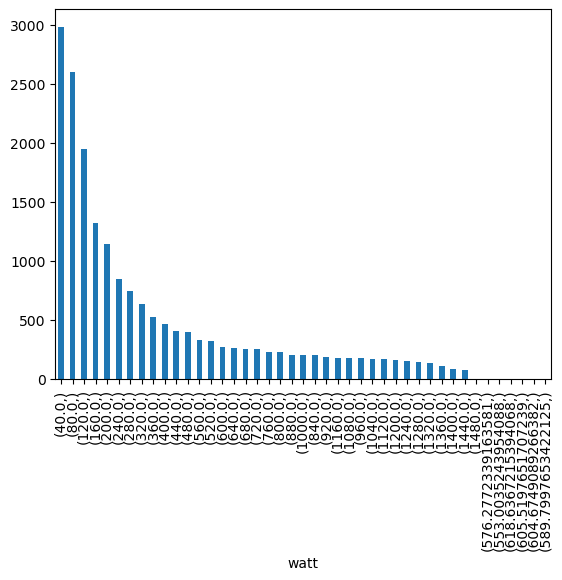

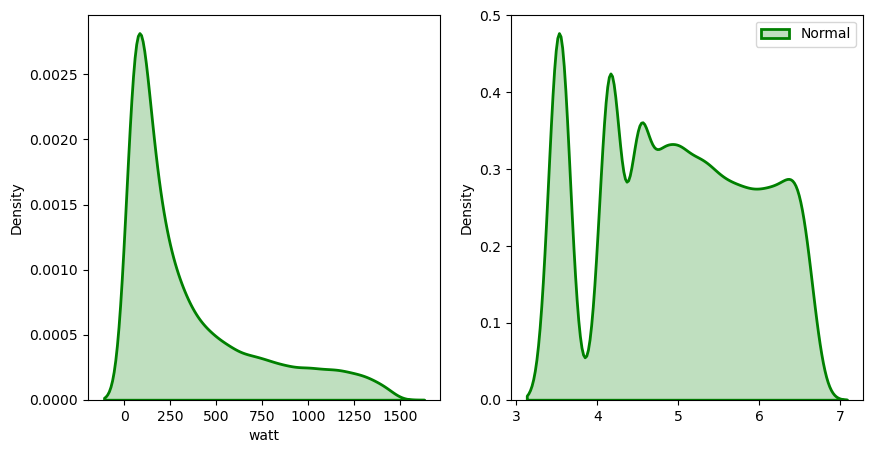

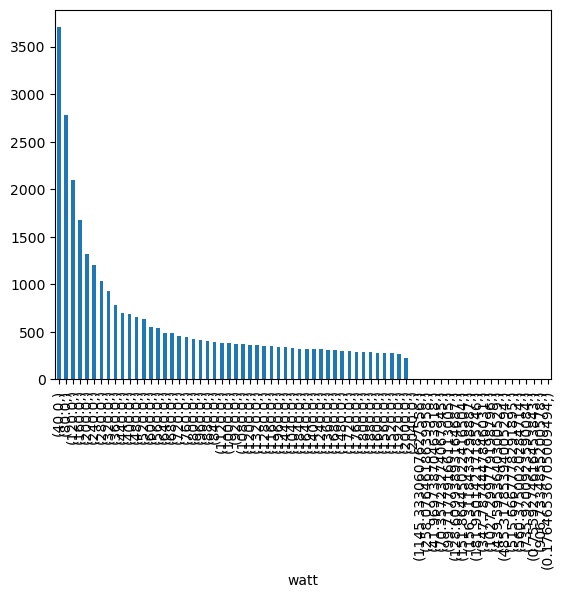

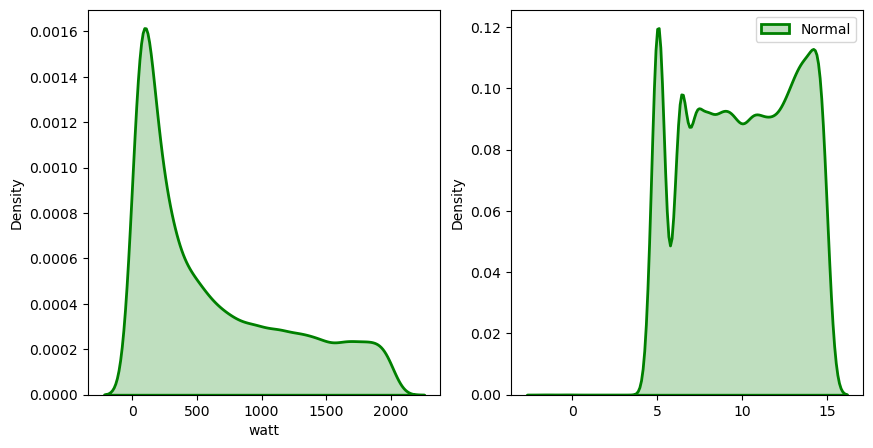

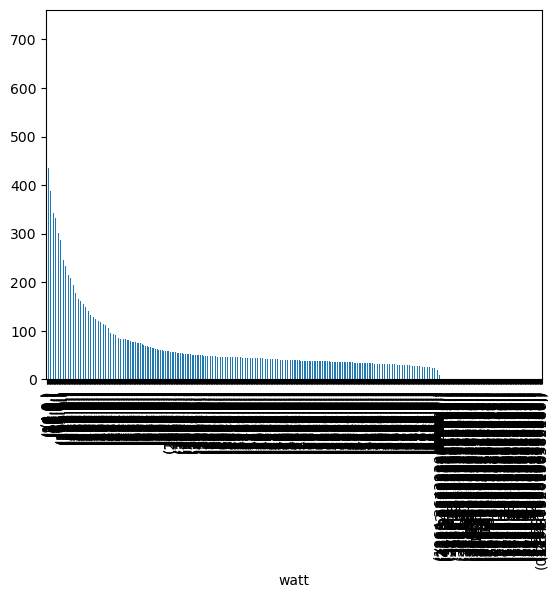

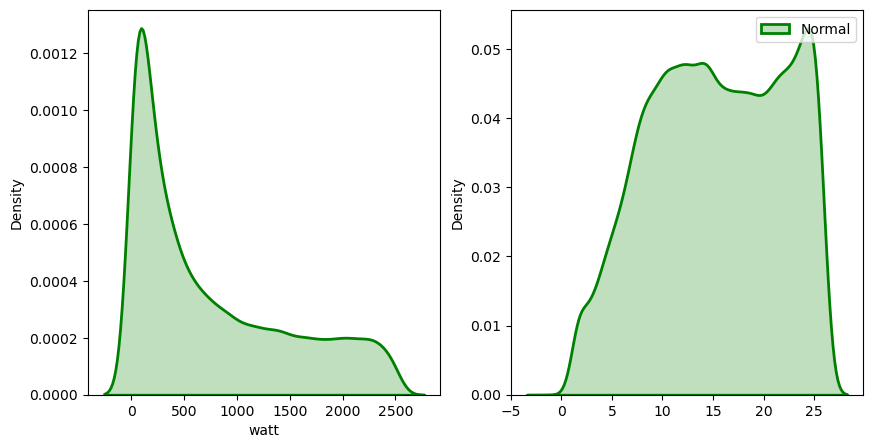

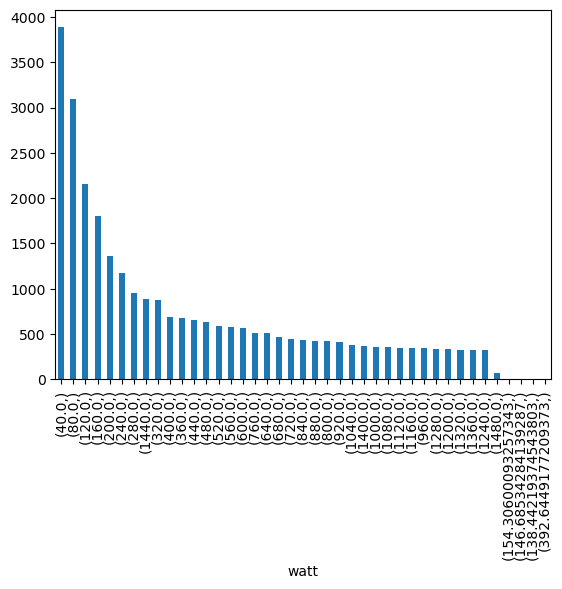

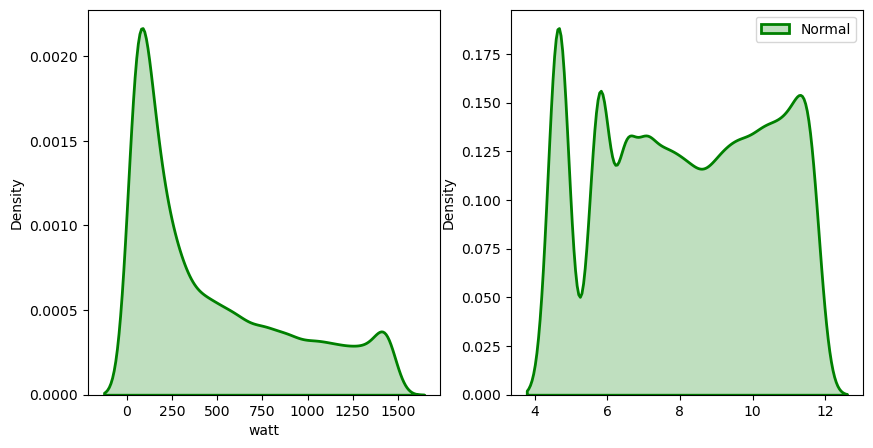

In [21]:
#Select some ID's of diverse locations in terms of total generated power and CF
ID_selection = ('2645JE56', '6721DC105', '1183RW15', '3437BD60', '9851BB13')

#Plot average daily generation profile for each location
for unique_id in ID_selection:
    installation_prod = prodNL.loc[(unique_id,)]
    peak_power = metadata.at[unique_id, "Watt Peak"]
    installation_prod = installation_prod.loc[~(installation_prod == 0).all(axis=1)]
    plt.figure()
    installation_prod.value_counts().plot.bar()
    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(installation_prod['watt'])
    
    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)
    
    # plotting the original data(non-normal) and 
    # fitted data (normal)
    sns.distplot(installation_prod['watt'], hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2}, 
                label = "Non-Normal", color ="green", ax = ax[0])
    
    sns.distplot(fitted_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2}, 
                label = "Normal", color ="green", ax = ax[1])
    
    # adding legends to the subplots
    plt.legend(loc = "upper right")
    
    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    
    print(f"Lambda value used for Transformation: {fitted_lambda}")


## Random

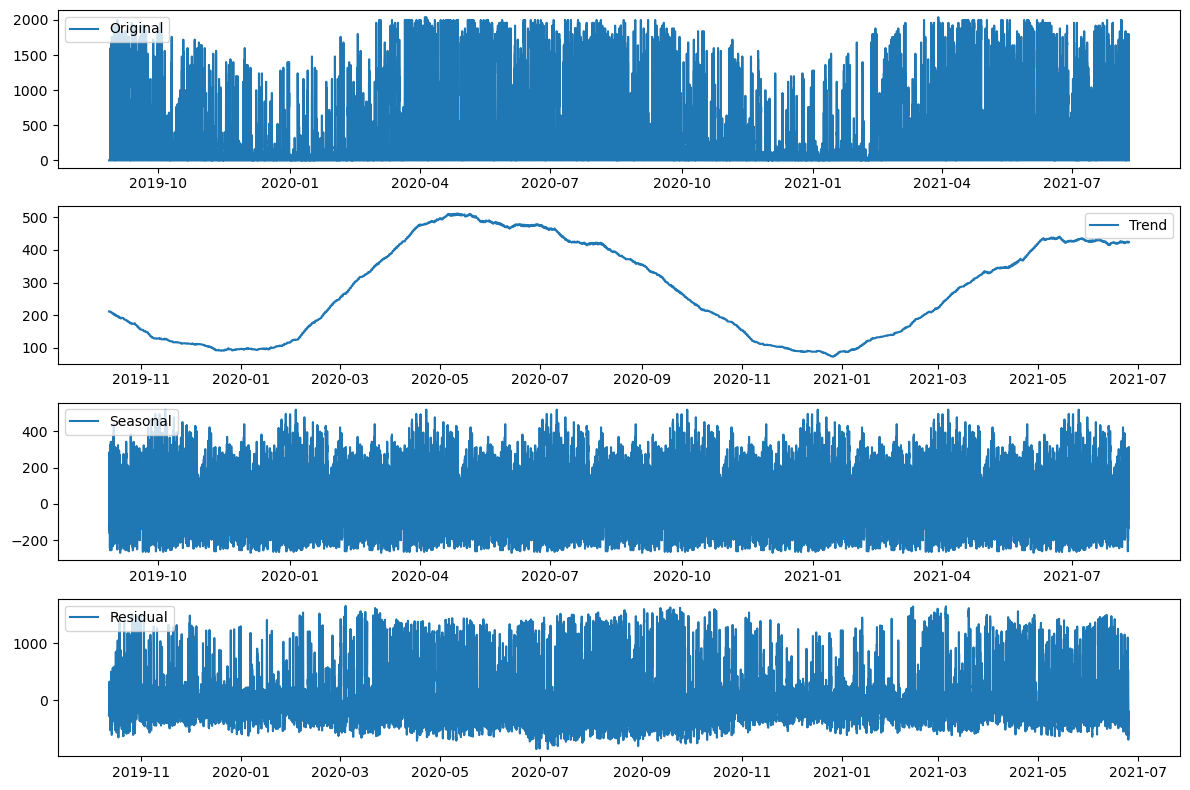

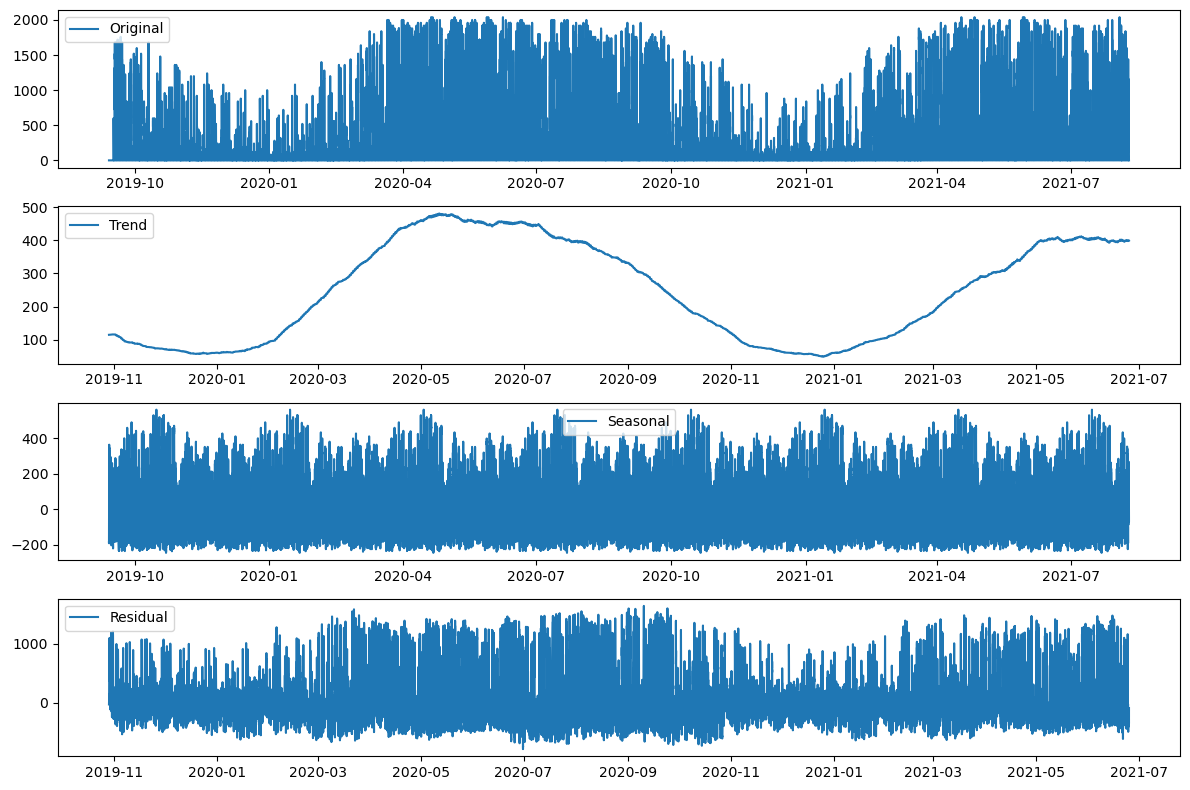

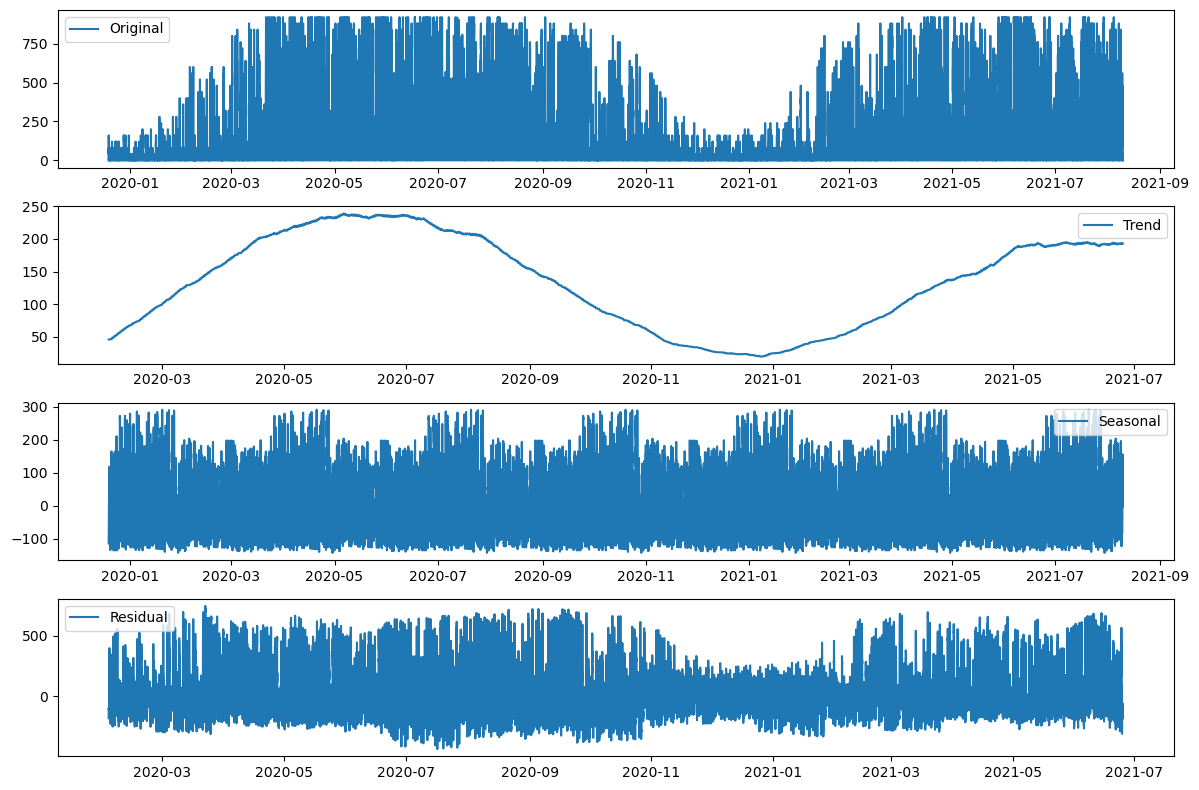

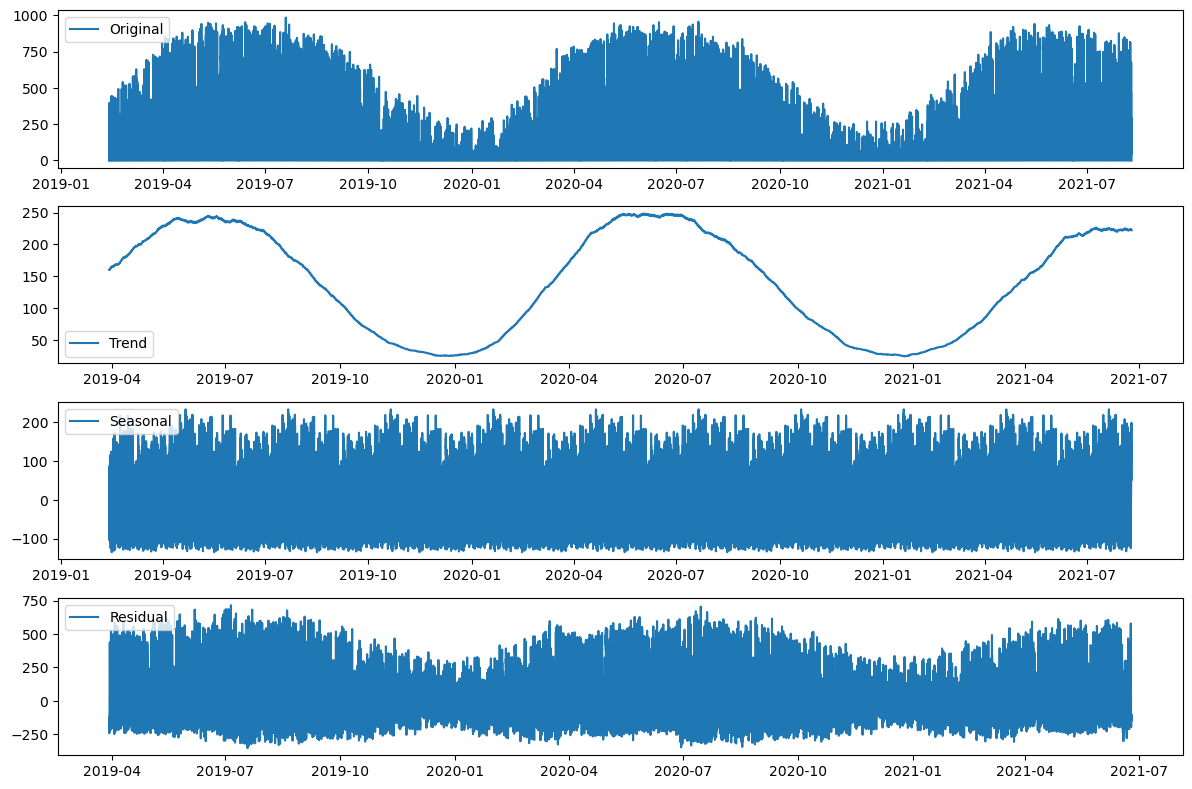

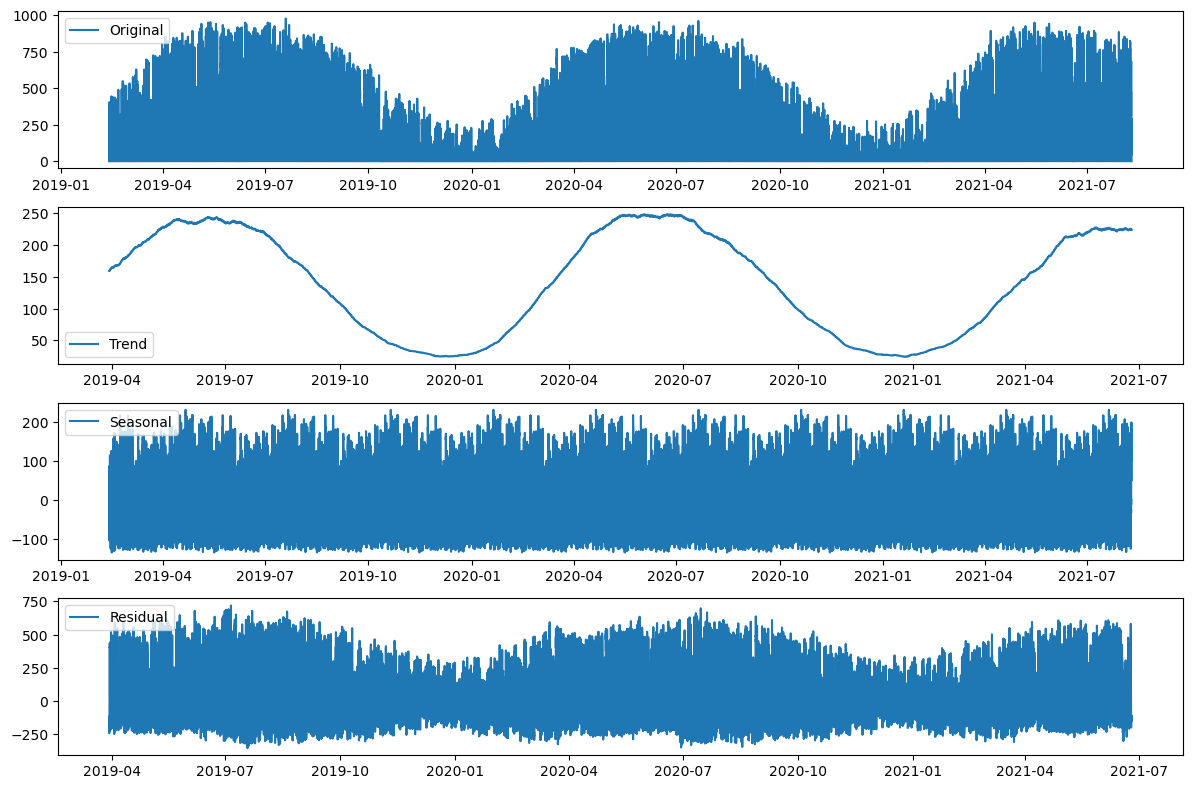

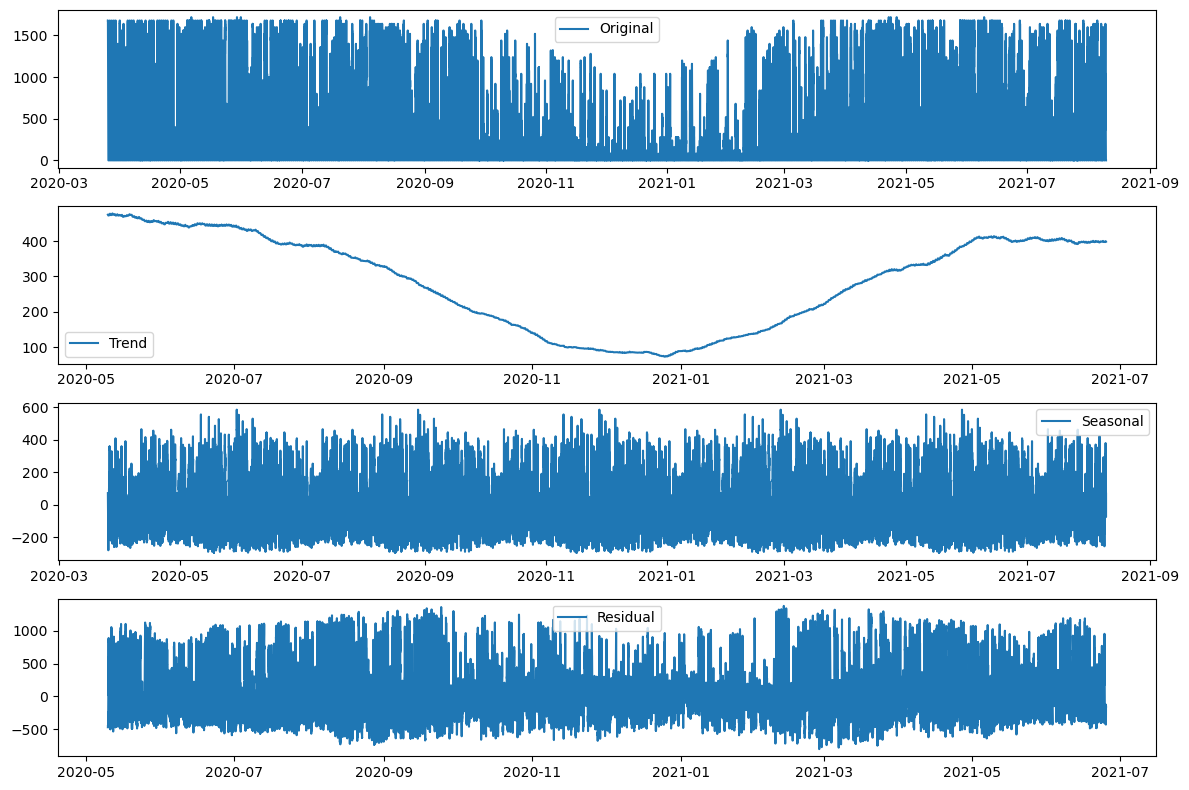

KeyboardInterrupt: 

In [131]:
#Playing around with seasonal decomposition
for unique_id, installation_prod in prodNL.groupby(level=0):
    installation_prod = installation_prod.droplevel(0)
    result = seasonal_decompose(installation_prod['watt'], model='additive', period=24*365)
    # Plot the decomposition results
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(installation_prod['watt'], label='Original')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()
